In [1]:
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from chempy.equilibria import EqSystem

In [2]:
data = [
    ["glycine", 2.34, 9.60, None, 5.97],
    ["alanine", 2.34, 9.69, None, 6.00],
    ["valine", 2.32, 9.62, None, 5.96],
    ["leucine", 2.36, 9.60, None, 5.98],
    ["isoleucine", 2.36, 9.60, None, 6.02],
    ["methionine", 2.28, 9.21, None, 5.74],
    ["proline", 1.99, 10.60, None, 6.30],
    ["phenylalanine", 1.83, 9.13, None, 5.48],
    ["tryptophan", 2.38, 9.39, None, 5.89],
    ["asparagine", 2.02, 8.80, None, 5.41],
    ["glutamine", 2.17, 9.13, None, 5.65],
    ["serine", 2.21, 9.15, None, 5.68],
    ["threonine", 2.09, 9.10, None, 5.60],
    ["tyrosine", 2.20, 9.11, 10.07, 5.66],
    ["cysteine", 1.96, 10.28, 8.18, 5.07],
    ["aspartic acid", 1.88, 9.60, 3.65, 2.77],
    ["glutamic acid", 2.19, 9.67, 4.25, 3.22],
    ["lysine", 2.18, 8.95, 10.53, 9.74],
    ["arginine", 2.17, 9.04, 12.48, 10.76],
    ["histidine", 1.82, 9.17, 6.00, 7.59],
]
df = pd.DataFrame(data, columns=["amino_acid", "pKa1", "pKa2", "pKa3", "pI"])
df

,amino_acid,pKa1,pKa2,pKa3,pI
0,glycine,2.34,9.60,NaN,5.97
1,alanine,2.34,9.69,NaN,6.00
2,valine,2.32,9.62,NaN,5.96
3,leucine,2.36,9.60,NaN,5.98
4,isoleucine,2.36,9.60,NaN,6.02
5,methionine,2.28,9.21,NaN,5.74
6,proline,1.99,10.60,NaN,6.30
7,phenylalanine,1.83,9.13,NaN,5.48
8,tryptophan,2.38,9.39,NaN,5.89
9,asparagine,2.02,8.80,NaN,5.41


In [3]:
def build_system(*pKas):
    eqs = [
        "H2O = H+ + OH-; 10**-14/55.4",
        "NaOH = Na+ + OH-; 10**100.",
    ]
    n = len(pKas)

    def species(j):  # j = number of deprotonations (0..n)
        hcount = n - j
        name = "Ac"
        if hcount > 0:
            name += "H" * hcount
        if j > 0:
            name += f"{-j:+}"  # numeric charge, e.g. -1, -2
        return name

    for j, pKa in enumerate(pKas):
        left = species(j)
        right = species(j + 1) + " + H+"
        eqs.append(f"{left} = {right}; 10**-{pKa}")

    return EqSystem.from_string("\n".join(eqs))


build_system(1, 2, 3)

In [4]:
def compute_equilibrium(*pKas, added_base):
    # number of dissociable protons
    n_forms = len(pKas)
    system = build_system(*pKas)

    # fully protonated species name must match build_system's pattern: Ac + 'H'*n
    acid_name = "Ac" + "H" * n_forms

    # initial amounts: fully protonated acid, water, and added base
    initial_concentrations = defaultdict(
        float,
        {
            "H2O": 55.4,
            acid_name: 1.0,  # was AcH{n_forms}, which didn't exist in the system
            "NaOH": added_base,
        },
    )

    with warnings.catch_warnings(record=True):
        equilibrium_concentrations, info, sane = system.root(initial_concentrations)

    conc = dict(zip(system.substances, equilibrium_concentrations))
    return conc

In [5]:
def plot(*pKas):
    concentration_titrant = np.linspace(0, 4, 200)

    equilibrium_results = [
        compute_equilibrium(*pKas, added_base=conc) for conc in concentration_titrant
    ]

    valid = [
        (cont, res["H+"])
        for cont, res in zip(concentration_titrant, equilibrium_results)
        if res is not None
    ]

    if not valid:
        raise ValueError("No valid equilibrium results found.")

    titrant_concentration, proton_concentration = map(np.array, zip(*valid))
    pH = -np.log10(proton_concentration)

    sns.lineplot(
        x=titrant_concentration, y=pH, label=f"pKa: {', '.join(map(str, pKas))}"
    )
    plt.ylim(0, 14)
    plt.xlabel("Titrant Concentration (M)")
    plt.ylabel("pH")
    plt.title("Titration Curve")

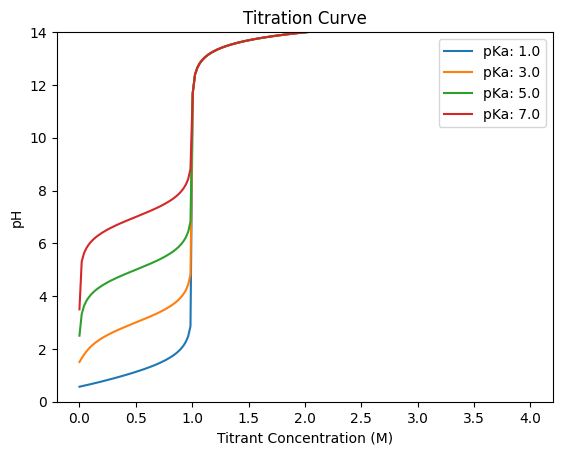

In [6]:
for pKa in [1.0, 3.0, 5.0, 7.0]:
    plot(pKa)

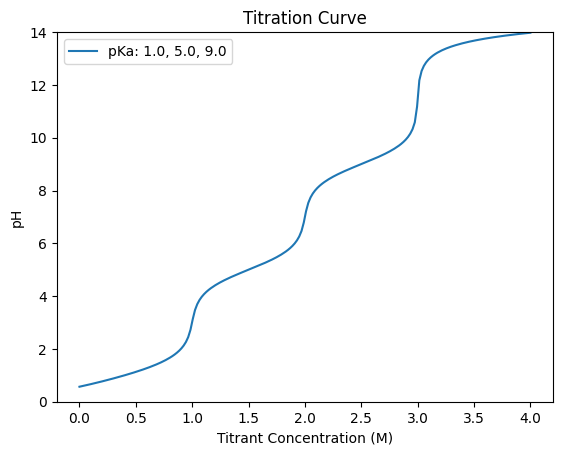

In [7]:
plot(1.0, 5.0, 9.0)